In [1]:
import os
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForMaskedLM
from transformers import DataCollatorForLanguageModeling
from transformers import AutoConfig
from torch.utils.data import DataLoader

import math
import os
from datasets import Dataset
from datasets import DatasetDict
from datasets import load_metric
from sklearn.model_selection import train_test_split
import json
import torch

In [2]:
NUM_LABELS = 5
chunk_size = 128

model_name = "neuralmind/bert-base-portuguese-cased"

In [3]:
ENCODING = {"label": {"Value": 0, "Value(+)": 1, "Value(-)": 2, "Fact": 3, "Policy": 4}}


def create_index_column(df):
    df["id"] = df.index + 1

def load_dataset():
    
    df_text = pd.DataFrame(pd.read_excel(os.path.join('./dataset', 'OpArticles.ods')))

    df_adu = pd.DataFrame(
        pd.read_excel(os.path.join('./dataset', 'aug.ods')))
    
    create_index_column(df_adu)
    
    return df_adu, df_text



def remove_dataframe_rows_by_id(df_to_remove, list_ids_to_remove):
    df_to_remove.set_index("id", inplace=True)

    df_to_remove.drop(list_ids_to_remove, inplace=True)

    df_to_remove.reset_index(inplace=True)


def split_train_test(df):
  
    train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
    
    val, test = train_test_split(test, test_size=0.5, random_state=42, stratify=test['label'])

    train = pd.DataFrame.from_dict(train)
    
    val = pd.DataFrame.from_dict(val)
    
    test = pd.DataFrame.from_dict(test)
    
    return train, val, test
    
def outlier_detection(df_adu):
    results = {}
    dict_collisions = {}
    for _, row in df_adu.iterrows():
        if row['article_id'] not in results.keys():
            results[row['article_id']] = {
                'A': [],
                'B': [],
                'C': [],
                'D': []
            }

        if row['annotator'] == 'A':
            results[row['article_id']]['A'].append({
                'id': row['id'],
                'ranges': row['ranges'],
                'tokens': row['tokens'],
                'label': row['label']
            })

        elif row['annotator'] == 'B':
            results[row['article_id']]['B'].append({
                'id': row['id'],
                'ranges': row['ranges'],
                'tokens': row['tokens'],
                'label': row['label']
            })

        elif row['annotator'] == 'C':
            results[row['article_id']]['C'].append({
                'id': row['id'],
                'ranges': row['ranges'],
                'tokens': row['tokens'],
                'label': row['label']
            })

        elif row['annotator'] == 'D':
            results[row['article_id']]['D'].append({
                'id': row['id'],
                'ranges': row['ranges'],
                'tokens': row['tokens'],
                'label': row['label']
            })

    for article_id in results.keys():

        for adu_A in results[article_id]['A']:
            adu_matching(adu_A, results[article_id]['B'], results[article_id]['C'], results[article_id]['D'],
                         dict_collisions)
        for adu_B in results[article_id]['B']:
            adu_matching(adu_B, results[article_id]['A'], results[article_id]['C'], results[article_id]['D'],
                         dict_collisions)
        for adu_C in results[article_id]['C']:
            adu_matching(adu_C, results[article_id]['A'], results[article_id]['B'], results[article_id]['D'],
                         dict_collisions)
        for adu_D in results[article_id]['D']:
            adu_matching(adu_D, results[article_id]['A'], results[article_id]['B'], results[article_id]['C'],
                         dict_collisions)

    return dict_collisions


def adu_matching(adu, list_annotater_X, list_annotater_Y, list_annotater_Z, dict_collisions):
    for iterator in [list_annotater_X, list_annotater_Y, list_annotater_Z]:
        for elem in iterator:
            if json.loads(adu['ranges'])[0][0] < json.loads(elem['ranges'])[0][0] < json.loads(adu['ranges'])[0][1]:
                if adu['label'] != elem['label']:
                    # print(f"Disagreement between:\n{adu['tokens']} \n and \n {elem['tokens']}")
                    if adu['id'] not in dict_collisions.keys():
                        dict_collisions[adu['id']] = [elem['id']]
                    else:
                        dict_collisions[adu['id']].append(elem['id'])


def deal_with_outliers(df_adu, dict_collisions, option='delete'):
    # print(f"Before:{df_adu.describe()}")

    if option == 'delete':
        list_to_remove = []

        for key_left in dict_collisions.keys():
            list_to_remove.append(key_left)
            for elem in dict_collisions[key_left]:
                list_to_remove.append(elem)

        remove_dataframe_rows_by_id(df_adu, list_to_remove)

    elif option == 'majority':
        list_to_remove = []
        for key_left in dict_collisions.keys():
            counters = {
                'Fact': 0,
                'Policy': 0,
                'Value': 0,
                'Value(+)': 0,
                'Value(-)': 0,
            }

            majority_vote = None
            number_votes = 0

            adu = df_adu.loc[df_adu['id'] == key_left].iloc[0]

            counters[adu['label']] += 1

            for elem in dict_collisions[key_left]:
                adu = df_adu.loc[df_adu['id'] == elem].iloc[0]
                counters[adu['label']] += 1

            for elem in counters.keys():
                number_votes += counters[elem]

            """
            Find the majority vote type
            Majority_Vote returns a Valid Label
            """

            for elem in counters.keys():
                if counters[elem] / number_votes >= 0.5:
                    majority_vote = elem
                    break

            if not majority_vote:
                continue

            if adu['label'] != majority_vote:
                list_to_remove.append(adu['id'])

            for elem in dict_collisions[key_left]:
                elem_adu = df_adu.loc[df_adu['id'] == elem].iloc[0]
                if elem_adu['label'] != majority_vote:
                    list_to_remove.append(elem_adu['id'])

        remove_dataframe_rows_by_id(df_adu, list_to_remove)

    # print(f"After:{df_adu.describe()}")
#ENCODING = {"label": {"Value": 0, "Value(+)": 1, "Value(-)": 2, "Fact": 3, "Policy": 4}}   
def augment_train(df_train):
    new_lines={
        'tokens':[],
        'label':[],
    }
    for _, row in df_train.iterrows():
        #if row['label'] == 1 or row['label'] == 4:
        if row['label'] == 4 :
            correct_str = row['augmented']
            
            en_str = row['en']
            sp_str = row['sp']
            
            if not row['tokens'][0].isupper():
                correct_str = correct_str[0].lower() + correct_str[1:]
                en_str = en_str[0].lower() + en_str[1:]
                sp_str = sp_str[0].lower() + sp_str[1:]
                        
            new_lines['tokens'].append(correct_str)
            new_lines['label'].append(row['label'])
            #new_lines['tokens'].append(en_str)
            #new_lines['label'].append(row['label'])
            #new_lines['tokens'].append(sp_str)
            #new_lines['label'].append(row['label'])
        
    df = pd.DataFrame(new_lines)
    
    return df_train.append(df, ignore_index = True)

In [4]:
def load_data_for_masking(df):
    
    df.drop(columns=['article_id', 'title', 'authors', 'meta_description', 'topics', 'keywords', 'publish_date',
                     'url_canonical'], inplace=True)
    
    df.rename(columns={'body': 'tokens'}, inplace=True)

    dataset = Dataset.from_pandas(df)

    train_test = dataset.train_test_split(test_size=0.2)

    
    train_valid_test_dataset = DatasetDict({
        'train': train_test['train'],
        'test': train_test['test'],        
    })

    return train_valid_test_dataset

def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result



In [5]:
def tokenize_function_2(examples):
    result = tokenizer(examples["tokens"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

def tokenize_function(example):
    return tokenizer(example["tokens"], padding=True)

In [6]:
df_adu, _ = load_dataset()

train, val, test = split_train_test(df_adu)

dict_collisions = outlier_detection(train)

deal_with_outliers(train, dict_collisions, 'delete')

train.drop(columns=['article_id', 'annotator', 'node', 'ranges','id'], inplace = True)
train.replace(ENCODING, inplace=True)
train.reset_index(drop=True, inplace=True)

val.drop(columns=['article_id', 'annotator', 'node', 'ranges','id'], inplace = True)
val.replace(ENCODING, inplace=True)
val.reset_index(drop=True, inplace=True)

test.drop(columns=['article_id', 'annotator', 'node', 'ranges','id'], inplace = True)
test.replace(ENCODING, inplace=True)
test.reset_index(drop=True, inplace=True)

train = augment_train(train)

In [7]:
def task_2():
    
    _, df_text = load_dataset()

    
    model = AutoModelForMaskedLM.from_pretrained(model_name, num_labels = NUM_LABELS)
    
    dataset = load_data_for_masking(df_text)

    tokenized_datasets = dataset.map(
        tokenize_function_2, batched=True, remove_columns=["tokens"]
    )

    lm_datasets = tokenized_datasets.map(group_texts, batched=True)

    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)
    
    max_layer = 11
    
    for name, param in model.named_parameters():
        for elem in range(max_layer-2):
            if name.startswith(f"bert.encoder.layer.{elem}."): # choose whatever you like here
                param.requires_grad = False
    #batch_size = 64
    # Show the training loss with every epoch
    #logging_steps = len(lm_datasets["train"]) // batch_size

    training_args = TrainingArguments(
        output_dir=f"{model_name}-finetuned-imdb",        
        evaluation_strategy="epoch",
        num_train_epochs=3,
        fp16=True,
        save_strategy='no'
    )


    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=lm_datasets["train"],
        eval_dataset=lm_datasets["test"],
        data_collator=data_collator,
    )


    eval_results = trainer.evaluate()
    print(f">>> Perplexity Before: {math.exp(eval_results['eval_loss']):.2f}")

    trainer.train()

    eval_results = trainer.evaluate()
    print(f">>> Perplexity After: {math.exp(eval_results['eval_loss']):.2f}")
    
    
    
    for name, param in model.named_parameters():
        if name.startswith(f"bert.encoder.layer.{elem}."): # choose whatever you like here
            param.requires_grad = True
    
    #batch_size = 64
    # Show the training loss with every epoch
    #logging_steps = len(lm_datasets["train"]) // batch_size

    training_args = TrainingArguments(
        output_dir=f"{model_name}-finetuned-imdb",        
        evaluation_strategy="epoch",
        num_train_epochs=2,
        fp16=True,
        save_strategy='no'
    )


    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=lm_datasets["train"],
        eval_dataset=lm_datasets["test"],
        data_collator=data_collator,
    )


    eval_results = trainer.evaluate()
    print(f">>> Perplexity Before: {math.exp(eval_results['eval_loss']):.2f}")

    trainer.train()

    eval_results = trainer.evaluate()
    print(f">>> Perplexity After: {math.exp(eval_results['eval_loss']):.2f}")
    
    
    config = AutoConfig.from_pretrained(model_name)
    config.num_labels = NUM_LABELS
    model = AutoModelForSequenceClassification.from_config(config)
    
    return model


In [8]:
train_valid_test_dataset = DatasetDict({
    'train': Dataset.from_pandas(train),
    'validation': Dataset.from_pandas(val),
    'test': Dataset.from_pandas(test)
})


tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

model = task_2()

tokenized_dataset = train_valid_test_dataset.map(tokenize_function, batched=True)

max_layer = 11
#max_layer = 24

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

/usr/local/lib/python3.6/dist-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "
Using amp half precision backend
The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 597
  Batch size = 8


The following columns in the training set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
/usr/local/lib/python3.6/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2662
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 999


>>> Perplexity Before: 11.08


Epoch,Training Loss,Validation Loss
1,No log,1.888990
2,2.059500,1.802909
3,2.059500,1.801823


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 597
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 597
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 597
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/mo

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 597
  Batch size = 8


>>> Perplexity After: 6.22


The following columns in the training set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 2662
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 666


>>> Perplexity Before: 5.98


Epoch,Training Loss,Validation Loss
1,No log,1.972661
2,1.328300,1.874308


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 597
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 597
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 597
  Batch

loading configuration file https://huggingface.co/neuralmind/bert-base-portuguese-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e716e2151985ba669e7197b64cdde2552acee146494d40ffaf0688a3f152e6ed.18a0b8b86f3ebd4c8a1d8d6199178feae9971ff5420f1d12f0ed8326ffdff716
Model config BertConfig {
  "_name_or_path": "neuralmind/bert-base-portuguese-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_tran

>>> Perplexity After: 6.67


  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [9]:
#ENCODING = {"label": {"Value": 0, "Value(+)": 1, "Value(-)": 2, "Fact": 3, "Policy": 4}}
from torch import nn
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss()
        #loss_fct = nn.CrossEntropyLoss(weight=torch.cuda.FloatTensor([0.11, 0.92, 0.52, 0.485, 0.97]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss



def compute_metrics(eval_pred):
    metric = load_metric("f1")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1_val = metric.compute(predictions=predictions, references=labels, average='macro')

    metric = load_metric("accuracy")
    acc_val = metric.compute(predictions=predictions, references=labels)

    return {
        'f1':f1_val['f1'],
        'accuracy':acc_val['accuracy'],
    }

for name, param in model.named_parameters():
    for elem in range(max_layer-5):
        if name.startswith(f"bert.encoder.layer.{elem}."): # choose whatever you like here
            param.requires_grad = False

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=7,
    logging_strategy="epoch",
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="no",
    fp16=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend


In [10]:
trainer.train()
trainer.evaluate()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens, augmented, en, sp. If tokens, augmented, en, sp are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 12390
  Num Epochs = 7
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1358


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.397000,1.340892,0.130435,0.483871
2,1.231300,1.289472,0.323330,0.438471
3,1.014000,1.244484,0.402697,0.496416
4,0.856500,1.249048,0.442719,0.523297
5,0.747900,1.330831,0.450050,0.502389
6,0.660900,1.396428,0.448658,0.503584
7,0.604100,1.461649,0.444599,0.495221


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens, augmented, en, sp. If tokens, augmented, en, sp are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1674
  Batch size = 64
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens, augmented, en, sp. If tokens, augmented, en, sp are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1674
  Batch size = 64
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens, augmented, en, sp. If tokens, augmented, en, sp are not expected by `BertForSequenceClassification.fo

{'eval_loss': 1.461648941040039,
 'eval_f1': 0.4445994720666321,
 'eval_accuracy': 0.49522102747909197,
 'eval_runtime': 4.1574,
 'eval_samples_per_second': 402.66,
 'eval_steps_per_second': 6.495,
 'epoch': 7.0}

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens, augmented, en, sp. If tokens, augmented, en, sp are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1675
  Batch size = 64


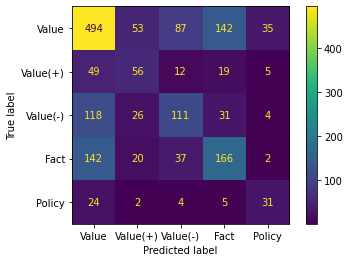

In [11]:
import torch
import torch.nn.functional as F
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predictions=trainer.predict(test_dataset=tokenized_dataset["test"])
preds = np.argmax(predictions.predictions, axis=-1)
confusion_matrix = metrics.confusion_matrix(tokenized_dataset['test']['label'], preds, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=["Value","Value(+)","Value(-)","Fact","Policy"])
disp.plot()
#print(confusion_matrix)
plt.show()

In [12]:
"""
!pip install xlrd
!pip install odfpy
!pip install ipywidgets widgetsnbextension pandas-profiling
!pip install datasets
!pip install transformers
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu110
"""

'\n!pip install xlrd\n!pip install odfpy\n!pip install ipywidgets widgetsnbextension pandas-profiling\n!pip install datasets\n!pip install transformers\n!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu110\n'

In [13]:
torch.cuda.empty_cache()
#!nvidia-smi